In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import helper

In [2]:
pd.set_option('display.max_rows', 160)
pd.set_option('display.max_colwidth', 500)

### Loading scraped data

In [3]:
#loading data from file
df = pd.read_parquet(path='datasets/euro_product_full_data.gzip')

In [4]:
null_df = pd.DataFrame({'col_name':((df.isna().sum()/len(df))*100).index,
                    'null_percent':((df.isna().sum()/len(df))*100).values}) \
                    .sort_values(by=['null_percent'], ascending=False)

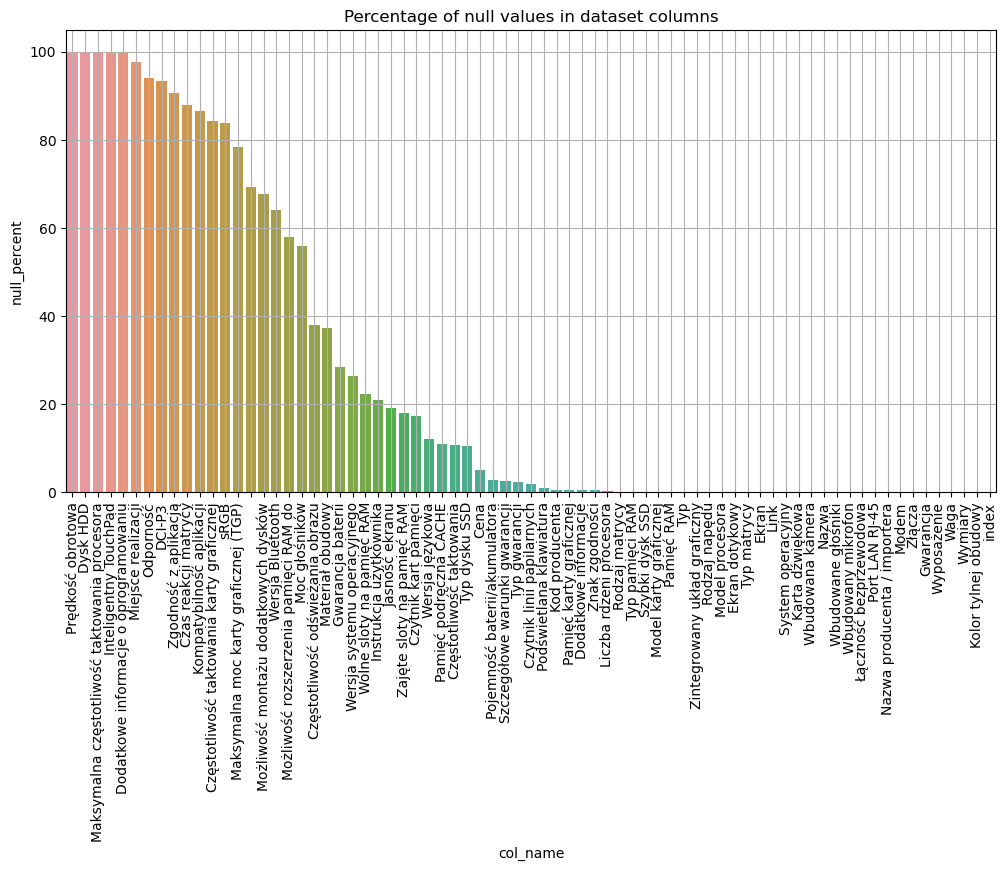

In [5]:
plt.figure(figsize=(12,6))
sns.barplot(null_df, x='col_name', y='null_percent')
plt.grid()
plt.xticks(rotation = 90)
plt.title("Percentage of null values in dataset columns")
plt.show()

## Initial analysis of columns

In [6]:
summ= pd.DataFrame(columns=['Name','NUnique','NotNull'])
summary = {}
for c in df.columns:
    summary['Name'] = c
    summary['NUnique'] = df[c].nunique()
    summary['NotNull'] =sum(df[c].notnull())
    data_row = pd.DataFrame.from_records(data=[summary])

    summ = pd.concat([summ, data_row])
    
summ.reset_index(inplace= True)
summ.drop(columns='index', inplace= True)
# summ.sort_values(by='NotNull', ascending=False)

### Kolumny do usunięcia
Zgodność z aplikacją - specyficzne dla HP
Miejsce realizacji - nieistotne
DCI-P3 - nieistotne
Odporność - trudne do uwzględnienia, mało danych
Kompatybilność aplikacji - nieistotne, mało danych
sRGB - nieistotny
"" - trudne do uwzględnienia
Moc głośników - nieistotny
Gwarancja baterii - nieistotne
Wersja systemu operacyjnego - dane zawarte w prostszy sposób w kolumnie 'System operacyjny'
Jasność ekranu - nieistotny
Wersja językowa - jednolite dane
Instrukcja użytkownika - nieistotny
Szczegółowe warunki gwarancji - nieistotne
Znak zgodności
Rodzaj napędu - jednolite dane
Karta dźwiękowa - nieistotne
Wbudowane głośniki - nieistotne
Dodatkowe informacje - dane chaotyczne, częściowo powielające się z informacjamiw innych kolumnach
Kolor tylnej obudowy - nieistotne
Wymiary - nieistotne
Waga - nieistotne
Wyposażenie - nieistotne
Modem - jednolite dane
index - nieistotne
Dodatkowe informacje o oprogramowaniu - mało danych
Inteligentny TouchPad - mało danych
Dysk HDD - mało danych
Prędkość obrotowa - mało danych

In [7]:
_columns_to_remove = 'Czas reakcji matrycy,Zgodność z aplikacją,Częstotliwość taktowania karty graficznej,'+\
    'Maksymalna moc karty graficznej (TGP),Wersja Bluetooth,Miejsce realizacji,DCI-P3,Odporność,Kompatybilność aplikacji,'+\
    'sRGB,,Moc głośników,Gwarancja baterii,Wersja systemu operacyjnego,Jasność ekranu,Wersja językowa,'+\
    'Instrukcja użytkownika,Szczegółowe warunki gwarancji,Znak zgodności,Rodzaj napędu,Karta dźwiękowa,Wbudowane głośniki,'+\
    'Dodatkowe informacje,Kolor tylnej obudowy,Wymiary,Waga,Wyposażenie,Modem,index,Inteligentny TouchPad,'+\
    'Dodatkowe informacje o oprogramowaniu,Dysk HDD,Prędkość obrotowa,Maksymalna częstotliwość taktowania procesora'
_columns_to_remove = _columns_to_remove.split(',')
len(_columns_to_remove)

34

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227 entries, 0 to 1226
Data columns (total 76 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   Nazwa                                            1227 non-null   object  
 1   Cena                                             1167 non-null   float64 
 2   Link                                             1227 non-null   object  
 3   Model procesora                                  1227 non-null   object  
 4   Kod producenta                                   1227 non-null   object  
 5   Cat_Brand                                        1227 non-null   object  
 6   Cat_Dystrybutor                                  1227 non-null   category
 7   Cat_Gwarancja                                    1227 non-null   category
 8   Cat_SSD_type                                     1227 non-null   category
 9   Cat_LAN            

In [9]:
df.drop(columns=_columns_to_remove, inplace=True)

# Czyszczenie danych

## Analiza jakościowa kolumn

### Kategoryzacja 
**Nazwa
**Typ gwarancji** --> kategoryzacja / null --> standard  
**Typ dysku SSD** --> kategoryzacja / PCI oraz M.2 połączyć  
**Port LAN RJ-45** - kategoryzacja  
**Typ** - kategoryzacja  
**Rodzaj matrycy** - kategoryzacja  
**System operacyjny** - kategoryzacja  
**Model procesora** - konwersja na producent / typ / generację - kategoryzacja  
**Materiał obudowy** - do uproszczenia do metal / plastik / mieszane  
**Nazwa producenta / importera** - kategoryzacja

### Binaryzacja
**Możliwość montażu dodatkowych dysków** - do binaryzacji / null => False  
**Czytnik kart pamięci** - binaryzacja  
**Podświetlana klawiatura** - binaryzacja  
**Czytnik linii papilarnych** - binaryzacja  
**Ekran dotykowy** - binaryzacja  
**Wbudowany mikrofon** - binaryzacja  
**Typ pamięci RAM** - binaryzacja DDR4 / DDR5  
**Typ matrycy** - binaryzacja  
**Łączność bezprzewodowa** - bez Bluetooth, podzielić na 2 typy (ax oraz ac)

### Konwersja na wartość ciągłą
**Zajęte sloty na pamięć RAM** - konwersja na int  
**Pamięć karty graficznej** - konwersja na int  
**Szybki dysk SSD** - konwersja na int  
**Gwarancja** - konwersja na int  
**Liczba rdzeni procesora** - konwersja na int  
**Pamięć RAM** - konwersja na int  
**Pojemność baterii/akumulatora** - konwersja na int  
**Pamięć podręczna CACHE** - konwersja na int  
**Wbudowana kamera** - konwersja MPix do int, uzupełnienie dla brakujących danych dominantą  
**Możliwość rozszerzenia pamięci RAM do** - zmienić jako "maksymalna wielkość RAM" i uzupełnić null aktualną wartością RAM 

### Uzupełnienie wartości null
 
**Częstotliwość odświeżania obrazu** - najniższa to 60, do uzupełnienia we wszystkich  
**Wolne sloty na pamięć RAM** - uzupełnić null -> 0  
**Kod producenta** - uzupełnić null nazwą produktu

### Porównanie z innym zbiorem
**Model karty graficznej** - porównać do danych z osobnego datasetu  
**Zintegrowany układ graficzny** - do ustalenia, czy potrzebne modyfikacje  

### Rozbicie na wiele kolumn
**Złącza** - rozdzielenie na interfejsy  
**Częstotliwość taktowania** - rozbicie na 'Taktowanie' oraz "Taktowanie Boost"  
**Ekran** - rozbicie na piksele oraz przekątną

**Sklep** - dodać nazwę sklepu przy rozszerzaniu o inne sklepy internetowe

In [10]:
column = 'Pamięć karty graficznej' #Uncomment relevant line for column summarise
print(df[column].info())
# df[df[column].notnull()][['Link', column]]
df[df[column].notnull()][column].value_counts()

<class 'pandas.core.series.Series'>
RangeIndex: 1227 entries, 0 to 1226
Series name: Pamięć karty graficznej
Non-Null Count  Dtype 
--------------  ----- 
1222 non-null   object
dtypes: object(1)
memory usage: 9.7+ KB
None


Pamięć karty graficznej
współdzielona z pamięcią systemową    823
4 GB                                  177
8 GB                                   99
6 GB                                   83
16 GB                                  17
12 GB                                  12
2 GB                                   11
Name: count, dtype: int64

## Converting to categories

In [11]:
column = 'Nazwa'
pattern = '[A-Z][A-Za-z0-9-]+'
df['Cat_Brand'] = df[column].apply(lambda string: re.findall(pattern, string)[1])
df['Cat_Brand'][df['Cat_Brand']== "Book"] = "Realme"

C:\Users\Pszemegg\AppData\Local\Temp\ipykernel_21304\1044972692.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cat_Brand'][df['Cat_Brand']== "Book"] = "Realme"


In [12]:
# df["Sklep"] = "Euro"
# df['Sklep'] = df['Sklep'].astype('category')
column = 'Nazwa producenta / importera'
if column in df.columns:
    df['Cat_Dystrybutor'] = df[column].astype('category')
    df.drop(columns=[column], inplace=True)

In [13]:
column = 'Typ gwarancji'
if column in df.columns:
    df["Cat_Gwarancja"] = df[column].apply(helper.get_warranty_type,args=(df[column].mode()[0],)).astype('category')
    df.drop(columns=[column], inplace=True)

In [14]:
column = 'Typ dysku SSD'
if column in df.columns:
    df["Cat_SSD_type"] = df[column].fillna(df[column].mode()[0]).astype('category')
    df.drop(columns=[column], inplace=True)

In [15]:
column = 'Port LAN RJ-45'
if column in df.columns:
    df["Cat_LAN"] = df[column].apply(helper.get_lan_type, args=("N/A",)).astype('category')
    df.drop(columns=[column], inplace=True)

In [16]:
column = 'Rodzaj matrycy'
if column in df.columns:
    df["Cat_Rodzaj matrycy"] = df[column].fillna(df[column].mode()[0]).astype('category')
    df.drop(columns=[column], inplace=True)

In [17]:
# Applies to column 
column = 'Typ'

# Merging similar types of PCs 
# laptop --> laptop 2w1
df.loc[df[column] =='laptop', column] = 'laptop 2w1'
# laptop dla nauczyciela --> laptop do pracy
df.loc[df[column] =='laptop dla nauczyciela', column] = 'laptop do pracy'
# laptop z certyfikatem Intel EVO --> laptop na co dzień
df.loc[df[column] =='laptop z certyfikatem Intel EVO', column] = 'laptop na co dzień'
# None --> laptop gamingowy
df.loc[df[column].isna(), column] = df[column].mode()[0]

df["Cat_Typ"] = df[column].astype('category')
df.drop(columns=[column], inplace=True)

In [18]:
# Applies to column 
column = 'System operacyjny'

# Merging similar types of OSs 
# Windows 10 Home Edition (możliwość darmowej aktualizacji do Windows 11) --> Windows 10 Home Edition
df.loc[df[column] =='Windows 10 Home Edition (możliwość darmowej aktualizacji do Windows 11)', column] = 'Windows 10 Home Edition'
# Chrome OS --> bez systemu
df.loc[df[column] =='Chrome OS', column] = 'bez systemu'
df.loc[df[column].isna(), column] = df[column].mode()[0]

df["Cat_OS"] = df[column].astype('category')
df.drop(columns=[column], inplace=True)

In [19]:
column = 'Materiał obudowy'
if column in df.columns:
    df["Cat_Obudowa"] = df[column].apply(helper.simplify_cover)
    df["Cat_Obudowa"].fillna(df["Cat_Obudowa"].mode()[0], inplace=True)
    df["Cat_Obudowa"] = df["Cat_Obudowa"].astype('category')
    df.drop(columns=[column], inplace=True)

## Binarize

In [20]:
column = 'Możliwość montażu dodatkowych dysków'
if column in df.columns:
    df["Bin_Dodatkowe Dyski"] = df[column].apply(helper.fun_binarize)
    df.drop(columns=[column], inplace=True)

In [21]:
column = 'Czytnik kart pamięci'
if column in df.columns:
    df["Bin_Czytnik kart"] = df[column].apply(helper.fun_binarize)
    df.drop(columns=[column], inplace=True)

In [22]:
column = 'Podświetlana klawiatura'
if column in df.columns:
    df["Bin_Podswietlana klawiatura"] = df[column].apply(helper.fun_binarize)
    df.drop(columns=[column], inplace=True)

In [23]:
column = 'Czytnik linii papilarnych'
if column in df.columns:
    df["Bin_Czytnik linii"] = df[column].apply(helper.fun_binarize)
    df.drop(columns=[column], inplace=True)

In [24]:
column = 'Ekran dotykowy'
if column in df.columns:
    df["Bin_Ekran dotykowy"] = df[column].apply(helper.fun_binarize)
    df.drop(columns=[column], inplace=True)

In [25]:
column = 'Wbudowany mikrofon'
if column in df.columns:
    df["Bin_Mikrofon"] = df[column].apply(helper.fun_binarize)
    df.drop(columns=[column], inplace=True)

In [26]:
column = 'Typ pamięci RAM'
if column in df.columns:
    df["Bin_RAM DDR5"] = df[column].apply(helper.is_DDR5)
    df.drop(columns=[column], inplace=True)

In [27]:
column = 'Typ matrycy'
if column in df.columns:
    df["Bin_Matowa matryca"] = df[column].apply(helper.is_mat)
    df.drop(columns=[column], inplace=True)

In [28]:
column = 'Łączność bezprzewodowa'
if column in df.columns:
    df["Bin_WiFi ax"] = df[column].apply(helper.is_WiFi_ax)
    df.drop(columns=[column], inplace=True)

## Numerical value conversion

In [29]:
column = 'Zajęte sloty na pamięć RAM'
if column in df.columns:
    df["Int_sloty RAM"] = df[column].apply(helper.get_first_number, args=(1,))
    df.drop(columns=[column], inplace=True)

In [30]:
column = 'Pamięć karty graficznej'
if column in df.columns:
    df["Int_Pamiec GPU"] = df[column].apply(helper.get_first_number, args=(0,))
    df.drop(columns=[column], inplace=True)

In [31]:
column = 'Gwarancja'
if column in df.columns:
    df["Int_Gwarancja"] = df[column].apply(helper.get_first_number, args=(12,))
    df.drop(columns=[column], inplace=True)

In [32]:
column = 'Liczba rdzeni procesora'
if column in df.columns:
    df["Int_Cores CPU"] = df[column].apply(helper.get_first_number, args=(2,))
    df.drop(columns=[column], inplace=True)

In [33]:
column = 'Pamięć RAM'
if column in df.columns:
    df["Int_Pamiec RAM"] = df[column].apply(helper.get_first_number, args=(4,))
    df.drop(columns=[column], inplace=True)

In [34]:
column = 'Pojemność baterii/akumulatora'
if column in df.columns:
    df["Int_Bateria[Wh]"] = df[column].apply(helper.get_first_number, args=(40,))
    df.drop(columns=[column], inplace=True)

In [35]:
column = 'Pamięć podręczna CACHE'
if column in df.columns:
    df["Int_Cache"] = df[column].apply(helper.get_first_number, args=(None,))
    df["Int_Cache"].fillna(value=df["Int_Cache"].mode()[0],inplace=True)
    df.drop(columns=[column], inplace=True)

In [36]:
column = 'Szybki dysk SSD'
if column in df.columns:
    df["Int_Pamiec SSD"] = df[column].apply(helper.get_memory)
    df.drop(columns=[column], inplace=True)

In [37]:
column = 'Wbudowana kamera'
if column in df.columns:
    df["Flt_Kamera[MP]"] = df[column].apply(helper.get_camera_data, args=(None,))
    df.drop(columns=[column], inplace=True)
    # fill NaN with the most common value for undefined resolutions
    df["Flt_Kamera[MP]"].fillna(df["Flt_Kamera[MP]"].mode()[0], inplace=True)

In [38]:
column = 'Możliwość rozszerzenia pamięci RAM do'
if column in df.columns:
    df["Int_Maximum RAM"] = df[[column,"Int_Pamiec RAM"]].apply(helper.get_max_ram, axis=1)
    df.drop(columns=[column], inplace=True)

## Fill NaN

In [39]:
column = 'Częstotliwość odświeżania obrazu'
if column in df.columns:
    df["Cat_Częstotliwość"] = df[column]
    df["Cat_Częstotliwość"].fillna(df['Cat_Częstotliwość'].mode()[0], inplace=True)
    df["Cat_Częstotliwość"] = df["Cat_Częstotliwość"].astype('category')
    df.drop(columns=[column], inplace=True)

In [40]:
column ='Wolne sloty na pamięć RAM'
if column in df.columns:
    df["Int_Wolne sloty RAM"] = df[column].fillna(0)
    df["Int_Wolne sloty RAM"] = df["Int_Wolne sloty RAM"].astype('int64')
    
    df.drop(columns=[column], inplace=True)    

In [41]:
column ='Kod producenta'
df[column] = df[column].fillna(df['Nazwa'])

## Split to multiple columns

In [42]:
column = 'Ekran'
if column in df.columns:
    df["Cat_Rozdzielczość"] = df[column].apply(lambda x: x.split(',')[-1]).astype('category')
    df['Cat_Cale'] = df[column].apply(helper.get_first_number).astype('category') #get only integer of diagonal
    df.drop(columns=[column], inplace=True)

    # Precised version of diagonal is not in use to remove single values - aggregation based on integer
#     df['Cat_Cale'] = df[[column,"Cat_Rozdzielczość"]].apply(lambda x: x[0].split(','+x[1])[0], axis=1)

In [43]:
column = 'Częstotliwość taktowania'
mode = df[column].mode()[0]
if column in df.columns:
    df[['Flt_CPU Clock','Flt_CPU Clock Boost']]= pd.DataFrame.from_records(
                                                            df[column].apply(helper.get_cpu_frequency, args=(mode,))
                                                            )
    df['Flt_CPU Clock'].fillna(df['Flt_CPU Clock'].min(), inplace=True)
    df['Flt_CPU Clock Boost'].fillna(df['Flt_CPU Clock Boost'].min(), inplace= True)
    df.drop(columns=[column], inplace=True)

In [44]:
unique_interfaces = set()
for interface in df['Złącza']:
    if interface is None:
        continue
    interface_list = helper.get_unique_interfaces(interface)
    unique_interfaces.update(interface_list)
interfaces = sorted(unique_interfaces)

In [45]:
column = 'Złącza'
values = [0 for i in range(len(unique_interfaces))]
interfaces = dict(zip(unique_interfaces,values))
unique_interfaces = [ "IF_" + interface  for interface in unique_interfaces ]
if column in df.columns:
    df[unique_interfaces]= pd.DataFrame.from_records(
                                        df[column].apply(helper.one_hot_encoding_interfaces, args=(interfaces,))
                                        )
    df.drop(columns=[column], inplace=True)

## Comparing CPU data with other dataset

**Note:** *difflib matching is very computing-extensive for bigger arrays, therefore it is more efficient to filter out particular manufacturers*

In [46]:
#loading data from file
df_cpu = pd.read_parquet(path='datasets/cpu_benchmark.gzip')

In [47]:
df_cpu.head()

,CPU mark,Thread Mark
AArch64 rev 2 (aarch64),2320,898
AArch64 rev 4 (aarch64),1813,588
AC8257V/WAB,728,497
Allwinner A133,703,423
Allwinner A523,1889,590


In [48]:
column = 'Model procesora'
df_unique_cpu = df[column].drop_duplicates().to_frame()

### To speed up matching process, CPUs are divided by manufacturer, matched separately and merged afterwards

In [49]:
intel_cpu = df_unique_cpu['Model procesora'].str.contains("intel", case=False)
df_intel =df_unique_cpu[intel_cpu][['Model procesora']].drop_duplicates().reset_index()
df_unique_cpu= df_unique_cpu[(intel_cpu.apply(lambda x: not(x)))].reset_index()[['Model procesora']]

df_intel_benchmark = df_cpu.reset_index()[df_cpu.reset_index()['index'].str.contains("intel",case=False)][['index','CPU mark']]
df_intel_benchmark['index'] = df_intel_benchmark['index'].apply(lambda cpu: re.sub("@.+$",'',cpu))
df_intel[['Cpu_Benchmark', 'Int_Cpu Performance']]= pd.DataFrame.from_records(
                                                    df_intel.reset_index()['Model procesora'].apply(
                                                        helper.get_cpu_benchmarks, args=(df_intel_benchmark,))
                                                    )

In [50]:
amd_cpu = df_unique_cpu['Model procesora'].str.contains("amd", case=False)
df_amd =df_unique_cpu[amd_cpu][['Model procesora']].drop_duplicates().reset_index()
df_unique_cpu= df_unique_cpu[(amd_cpu.apply(lambda x: not(x)))].reset_index()

df_amd_benchmark = df_cpu.reset_index()[df_cpu.reset_index()['index'].str.contains("amd",case=False)][['index','CPU mark']]
df_amd[['Cpu_Benchmark', 'Int_Cpu Performance']]= pd.DataFrame.from_records(
                                                    df_amd.reset_index()['Model procesora'].apply(
                                                        helper.get_cpu_benchmarks, args=(df_amd_benchmark,))
                                                    )

In [51]:
apple_cpu = df_unique_cpu['Model procesora'].str.contains("apple", case=False)
df_apple =df_unique_cpu[apple_cpu][['Model procesora']].drop_duplicates().reset_index()
df_unique_cpu= df_unique_cpu[(apple_cpu.apply(lambda x: not(x)))].reset_index()

df_apple_benchmark = df_cpu.reset_index()[df_cpu.reset_index()['index'].str.contains("apple",case=False)][['index','CPU mark']]
df_apple_benchmark['index'] = df_apple_benchmark['index'].apply(lambda cpu: re.sub("\d+\sCore.*$",'',cpu))
df_apple[['Cpu_Benchmark', 'Int_Cpu Performance']]= pd.DataFrame.from_records(
                                                    df_apple.reset_index()['Model procesora'].apply(
                                                        helper.get_cpu_benchmarks, args=(df_apple_benchmark,))
                                                    )

In [52]:
other_cpu = df_unique_cpu['Model procesora']
df_other =df_unique_cpu['Model procesora'].reset_index()

df_other_benchmark = df_cpu.reset_index()[df_cpu.reset_index()['index'].str.contains("other",case=False)][['index','CPU mark']]
df_other_benchmark['index'] = df_other_benchmark['index'].apply(lambda cpu: re.sub("\d+\sCore.*$",'',cpu))
df_other[['Cpu_Benchmark', 'Int_Cpu Performance']]= pd.DataFrame.from_records(
                                                    df_other.reset_index()['Model procesora'].apply(
                                                        helper.get_cpu_benchmarks, args=(df_cpu.reset_index(),))
                                                    )

In [53]:
df_unique_cpu = pd.concat(
                    [df_intel, df_amd, df_apple, df_other],
                    ignore_index=True
                    ).drop(columns=['index']).set_index('Model procesora')

In [54]:
if 'Int_Cpu Performance' not in df.columns:
    df = df.join(df_unique_cpu, on='Model procesora', validate='m:1')

## Comparing GPU data with other dataset

In [55]:
df_gpu = pd.read_csv('datasets/GPU_benchmarks_v7.csv')

In [56]:
df['Bin_dodatkoweGpu']= df[['Zintegrowany układ graficzny','Model karty graficznej']].apply(lambda x: int(x[0]!=x[1]),  axis=1)

In [57]:
column = 'Model karty graficznej'
if column in df.columns:
    df[['Gpu_Benchmark', 'Int_Gpu Performance']]= pd.DataFrame.from_records(
                                                        df[column].apply(helper.get_gpu_benchmarks, args=(df_gpu[['gpuName','G3Dmark']],))
                                                        )
    df.drop(columns=[column], inplace=True)

In [58]:
# aggregating highly correlated data to get mean value for missing values of GPU performance
gpu_relation = df[['Int_Pamiec GPU','Int_Gpu Performance']].dropna().groupby('Int_Pamiec GPU').mean().astype("int64").to_dict()
df['Int_Gpu Performance'].fillna(df['Int_Pamiec GPU'].map(gpu_relation['Int_Gpu Performance']), inplace=True)

In [59]:
column = 'Zintegrowany układ graficzny'
if column in df.columns:
    df[['Gpu_Zintegrowana_Benchmark', 'Int_Gpu Zintegrowana Performance']]= pd.DataFrame.from_records(
                                                        df[column].apply(helper.get_gpu_benchmarks, args=(df_gpu[['gpuName','G3Dmark']],))
                                                        )
    
    df.drop(columns=[column], inplace=True)    

In [60]:
# aggregating highly correlated data to get mean value for missing values of GPU performance
gpu_relation = df[['Int_Pamiec GPU','Int_Gpu Zintegrowana Performance']].dropna().groupby('Int_Pamiec GPU').mean().astype("int64").to_dict()
df['Int_Gpu Zintegrowana Performance'].fillna(df['Int_Pamiec GPU'].map(gpu_relation['Int_Gpu Zintegrowana Performance']), inplace=True)

In [63]:
#saving cleaned data to file
df.to_parquet(path='datasets/euro_processed_full_data.gzip',
              compression='gzip')